In [1]:
cd "/home/enesk/repos/spatial-prediction"

/home/enesk/repos/spatial-prediction


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import reverb
import pandas as pd
from datetime import datetime
import random
from matplotlib import rc
import matplotlib
from active_sensing_environment import ExplorationEnvironment
from rl_env import RLEnv
import custom_py_driver


import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network

2023-05-25 12:56:05.515886: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(os.environ['LD_LIBRARY_PATH'])
print(os.environ['XLA_FLAGS'])


/home/enesk/miniconda3/envs/triad4/lib/:/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorrt_libs/
--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,' # We don't need a GPU to test the model

In [5]:
class TemperatureSchedule:
    def __init__(self):
        self.temp = 0.0
    def get_temp(self,):
        return self.temp

In [6]:
# Training parameters
all_params = {
"num_iterations" :  2000000, # @param {type:"integer"}
"n_step_update" :  5,
"initial_collect_steps" :  1000000,  # 30000 @param {type:"integer"}
"collect_steps_per_iteration" :    1,# @param {type:"integer"}
"replay_buffer_max_length" :  2000000,  # @param {type:"integer"}
"batch_size" :  64, # @param {type:"integer"}
"learning_rate" :  5e-5,  # @param {type:"number"}
"log_interval" :  200,  # @param {type:"integer"}
"gamma" :  0.99,
"boltzmann_temperature" :  None, # temp_schedule.get_temp
"fc_layer_params" :  (512, 20),
"epsilon" :  0.1,
"model_restore_path" : None, 
"conv_layer_params" : [(32,4,4), (64,4,4), (128,2,2)],
"target_update_tau" :  1,
"target_update_period" :  10000,
"num_eval_episodes" :  200,  # @param {type:"integer"}
"eval_interval" :  50000 , # @param {type:"integer"}
"single_env" :   False,
"use_sd" :  True,
"clairvoyante" :  False,
"num_atoms" : 70,  # @param {type:"integer"}
"min_q_value" : 0,  # @param {type:"integer"}
"max_q_value" : 20, # @param {type:"integer"}
"use_imitation_learning" : False,
"use_pretrain_imitation_learning" : "pretrain_q_learning",
}

for key,val in all_params.items():
    exec(key + '=val')

In [7]:
# Setup environment 
session_name = 'rand_walk_interpol'
env = RLEnv(model_path=session_name, single_env = single_env, use_sd=use_sd, 
                clairvoyante = clairvoyante, use_imitation_learning=use_imitation_learning)



2023-05-25 12:56:11.369089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 12:56:11.372826: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 12:56:11.373001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Unet Layers Shapes:
(None, 96, 96, 2)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/j

2023-05-25 12:56:15.325851: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 12:56:15.326045: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-25 12:56:15.326161: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-25 12:56:15.326436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 12:56:15.326692: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-05-25 12:56:15.954342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 12:56:15.954541: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-25 12:56:15.954832: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-25 12:56:15.955069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 12:56:15.955234: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-05-25 12:56:18.636271: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 12:56:18.636465: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-25 12:56:18.636544: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-25 12:56:18.636803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 12:56:18.636981: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-05-25 12:56:18.942719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 12:56:18.942928: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-05-25 12:56:18.943013: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-25 12:56:18.943264: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-25 12:56:18.943433: I tensorflow/compiler/xla/stream_executor/

In [8]:
# Storage folder
rl_session_name = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
#rl_session_name = '2023-05-13--21:30:16'
base_dir = "/home/enesk/repos/spatial-prediction/models/RL"
train_log_dir = base_dir +'/' + rl_session_name
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_summary_writer.set_as_default()
rl_session_name

'2023-05-25--12:56:19'

In [9]:
# Convert to TF environment
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [10]:

def main():
    env.ee.policy = "random"
    env.ee.action_space.repeat_probability = 0.9
    all_rewards = []
    final_errors = []
    
    for _ in range(1):
        time_step = train_py_env.reset()
        reward_in_episode = 0
        while not time_step.is_last():
            time_step = train_py_env.step(action=1)
            reward_in_episode += time_step.reward
        all_rewards.append(reward_in_episode)
        final_errors.append(env.current_error)
    print("Reward per epsisode", np.mean(all_rewards))
    print("Average error", np.mean(final_errors))
    env.ee.policy = "rl"

%lprun -u 1e-3 -f train_py_env.ee.predict_ss main()

2023-05-25 12:56:20.475255: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2023-05-25 12:56:20.475354: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2023-05-25 12:56:25.357680: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1330] [TF-TRT] Sparse compute capability: enabled.


Reward per epsisode 1.8400000240653753
Average error 37.6820719281615


Timer unit: 0.001 s

Total time: 70.2509 s
File: /home/enesk/repos/spatial-prediction/active_sensing_environment.py
Function: predict_ss at line 405

Line #      Hits         Time  Per Hit   % Time  Line Contents
   405                                           	def predict_ss(self, user_idx =0, no_full_covariance = False):
   406       202          0.6      0.0      0.0  		city_ob = self.building_grid
   407       202          0.6      0.0      0.0  		pwr_ob = self.ss_grids[user_idx]
   408       202          1.1      0.0      0.0  		indoor = self.building_grid > self.flying_altitude
   409                                           
   410                                           		# Get measured coords
   411       202         20.0      0.1      0.0  		measured_coords = self.get_measured_coords()
   412                                           
   413                                           		# UAV location grid
   414       202          1.1      0.0      0.0  		uav_location_grid

In [11]:
# Q-network 
q_net = categorical_q_network.CategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    num_atoms=51,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)


In [12]:
# DQN Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0, dtype=tf.int64)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    epsilon_greedy=epsilon,
    categorical_q_network=q_net,
    optimizer=optimizer,
    n_step_update=n_step_update,
    boltzmann_temperature=boltzmann_temperature,
    gamma=gamma,
    min_q_value=0,
    max_q_value=max_q_value,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

2023-05-25 12:57:30.613988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-05-25 12:57:31.176344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [13]:
# Define eval function
def compute_avg_return(environment, py_environment, policy, num_episodes=10):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
    episode_errors.append(py_environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0], np.mean(episode_errors)

In [14]:
# Eval random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

rand_reward, rand_pred_error = compute_avg_return(eval_env, eval_py_env, random_policy, num_episodes=1)

print((rand_reward, rand_pred_error))


(14.78998, 27.677414759792875)


In [15]:
# Experience storage
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=n_step_update+1,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,     
  sequence_length=n_step_update+1)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpfibin2kr.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpfibin2kr
[reverb/cc/platform/default/server.cc:71] Started replay server on port 33489


In [18]:


custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    use_imitation_learning = use_pretrain_imitation_learning,
    max_steps=initial_collect_steps).run(train_py_env.reset())

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=n_step_update+1).prefetch(3)

iterator = iter(dataset)


Traversed 9999 steps
Traversed 19999 steps
Traversed 29999 steps
Traversed 39999 steps
Traversed 39999 steps
Traversed 49999 steps
Traversed 59999 steps
Traversed 69999 steps
Traversed 79999 steps
Traversed 89999 steps
Traversed 99999 steps
Traversed 109999 steps
Traversed 119999 steps
Traversed 129999 steps
Traversed 139999 steps
Traversed 149999 steps
Traversed 159999 steps
Traversed 169999 steps
Traversed 179999 steps
Traversed 189999 steps
Traversed 199999 steps
Traversed 209999 steps
Traversed 219999 steps
Traversed 229999 steps
Traversed 239999 steps
Traversed 249999 steps
Traversed 259999 steps
Traversed 269999 steps
Traversed 279999 steps
Traversed 289999 steps
Traversed 299999 steps
Traversed 309999 steps
Traversed 319999 steps
Traversed 329999 steps
Traversed 339999 steps
Traversed 349999 steps
Traversed 359999 steps
Traversed 369999 steps
Traversed 379999 steps
Traversed 389999 steps
Traversed 399999 steps
Traversed 409999 steps
Traversed 419999 steps
Traversed 429999 steps


In [20]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 100)
returns, pred_errors = [avg_return], [avg_error]
returns_collect, pred_errors_collect = [], []

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    use_imitation_learning=use_imitation_learning,
    max_steps=collect_steps_per_iteration)



In [21]:
env._reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([[[ 0.02036073,  0.17810443,  0.        ],
        [ 0.0582964 ,  0.17810443,  0.        ],
        [ 0.01902046,  0.17810443,  0.        ],
        ...,
        [ 0.1496812 ,  0.178573  ,  0.        ],
        [ 0.08333137,  0.178573  ,  0.        ],
        [ 0.22343881,  0.178573  ,  0.        ]],

       [[ 0.06529201,  0.17810443,  0.        ],
        [ 0.08982423,  0.17810443,  0.        ],
        [ 0.05191947,  0.17810443,  0.        ],
        ...,
        [ 0.09553691,  0.178573  ,  0.        ],
        [ 0.16784343,  0.178573  ,  0.        ],
        [ 0.49540552,  0.178573  ,  0.        ]],

       [[-0.01320276,  0.17810443,  0.        ],
        [ 0.00932715,  0.17810443,  0.        ],
        [-0.00927811,  0.17810443,  0.        ],
        ...,
        [ 0.21376969,  0.178573  ,  0.        ],
        [ 0.30043843,  0.178573  ,  0.        ],
        [ 0.61614484,  0.178573  ,  0.        ]],

       .

In [22]:
if model_restore_path != None:
    checkpoint_dir = os.path.join(model_restore_path, 'checkpoint')
    train_checkpointer = common.Checkpointer(
        ckpt_dir=checkpoint_dir,
        max_to_keep=1,
        agent=agent,
        policy=agent.policy,
    )
    train_checkpointer.initialize_or_restore()

checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [23]:
best_reward = np.inf
num_eval_episodes = 100
losses = []
collect_rewards = []

In [25]:
if (use_pretrain_imitation_learning) != False:
  for i in range(1000000):
    # Sample a batch of data from the buffer and update the agent's network.
    step = agent.train_step_counter.numpy()
    experience, unused_info = next(iterator)
    loss_info = agent.train(experience)
    train_loss = loss_info.loss
    losses.append(train_loss)
    rew = np.mean((experience.reward))
    collect_rewards.append(rew)
    if step % 1000 == 0:
      print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, rew))
      with tf.name_scope("Training/"):
        tf.compat.v2.summary.scalar(name="Reward", data=rew*env.episode_length, step=step)
        tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)

step = 1000: loss = 3.901597738265991,  rew = 0.07352864742279053
step = 2000: loss = 3.9005703926086426,  rew = 0.07451822608709335
step = 3000: loss = 3.899153232574463,  rew = 0.08059895783662796
step = 4000: loss = 3.8956263065338135,  rew = 0.07938802242279053
step = 5000: loss = 3.901395320892334,  rew = 0.07791666686534882
step = 6000: loss = 3.894986391067505,  rew = 0.07493489980697632
step = 7000: loss = 3.8962979316711426,  rew = 0.07493489235639572
step = 8000: loss = 3.8959171772003174,  rew = 0.07217448204755783
step = 9000: loss = 3.895918607711792,  rew = 0.08171875029802322
step = 10000: loss = 3.886399745941162,  rew = 0.06763020902872086
step = 11000: loss = 3.866516590118408,  rew = 0.07083333283662796
step = 12000: loss = 3.8583056926727295,  rew = 0.07739583402872086
step = 13000: loss = 3.8570854663848877,  rew = 0.08269531279802322
step = 14000: loss = 3.8557958602905273,  rew = 0.0781770870089531
step = 15000: loss = 3.8574917316436768,  rew = 0.083880208432674

KeyboardInterrupt: 

In [28]:
for _ in range(1000000000):
  step = agent.train_step_counter.numpy()

  # Calculate betta for dagger
  if use_imitation_learning != False:
    start_beta = 0.999
    step_range = 4E6
    end_beta = 0.0
    beta = start_beta - (start_beta-end_beta) * step / step_range
    collect_driver._dagger_beta = beta

  

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  loss_info = agent.train(experience)
  train_loss = loss_info.loss
  losses.append(train_loss)
  rew = np.mean((experience.reward))
  collect_rewards.append(time_step.reward)

  

  if step % 1000 == 0:
    
    print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, np.mean(collect_rewards)*env.episode_length))
    with tf.name_scope("Training/"):
      tf.compat.v2.summary.scalar(name="Reward", data=np.mean(collect_rewards)*env.episode_length, step=step)
      tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
    collect_rewards = []

  if step % eval_interval == 0:
    avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, num_eval_episodes)
    #avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Average Error = {2}'.format(step, avg_return, avg_error))
    returns.append(avg_return)
    pred_errors.append(avg_error)
    with tf.name_scope("Testing/"):
      tf.compat.v2.summary.scalar(name="Reward", data=avg_return, step=step)
      tf.compat.v2.summary.scalar(name="Error", data=avg_error, step=step)

    if best_reward > avg_error:
      print("Saving model")
      best_reward = avg_error
      train_checkpointer.save(step)

step = 829000: loss = 2.488877773284912,  rew = 15.55885523557663
step = 830000: loss = 2.480950355529785,  rew = 17.536000907421112
step = 831000: loss = 2.41267728805542,  rew = 15.1869997382164
step = 832000: loss = 2.552511215209961,  rew = 9.196000546216965
step = 833000: loss = 2.4289846420288086,  rew = 9.258000552654266
step = 834000: loss = 2.3537182807922363,  rew = 9.565000236034393
step = 835000: loss = 2.4565768241882324,  rew = 11.242000013589859
step = 836000: loss = 2.504925012588501,  rew = 13.52900117635727
step = 837000: loss = 2.4762630462646484,  rew = 12.268999963998795
step = 838000: loss = 2.4297118186950684,  rew = 10.879001021385193
step = 839000: loss = 2.4288997650146484,  rew = 14.926999807357788
step = 840000: loss = 2.4365949630737305,  rew = 12.657000124454498
step = 841000: loss = 2.4306609630584717,  rew = 12.74000108242035
step = 842000: loss = 2.477490186691284,  rew = 12.200000137090683
step = 843000: loss = 2.4880318641662598,  rew = 12.79100030660

In [ ]:
temp_schedule.temp = 0.0

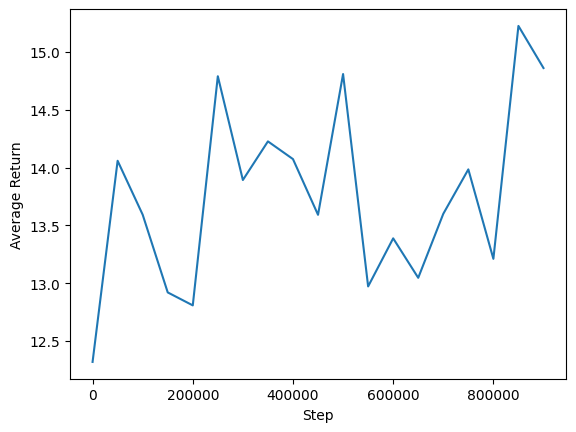

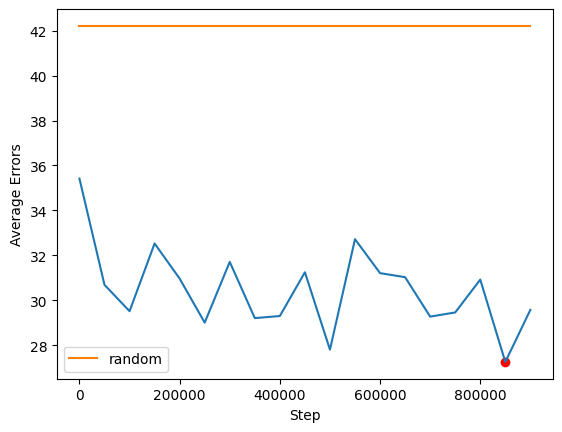

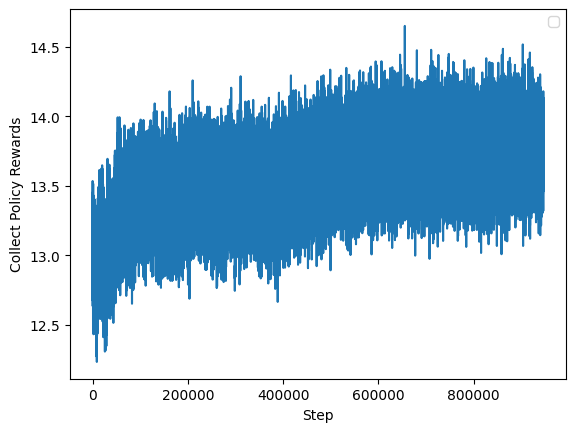

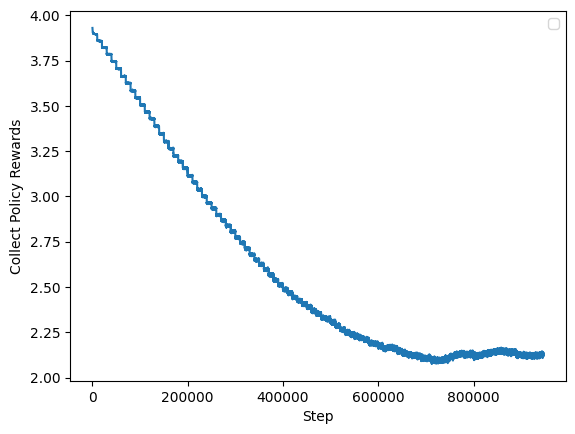

In [ ]:
%matplotlib inline
steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, pred_errors)
plt.plot(steps, np.ones(len(pred_errors))*rand_pred_error, label = "random")
plt.scatter([steps[np.argmin(pred_errors)]], [np.min(pred_errors)], c = 'r')
plt.ylabel('Average Errors')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(collect_rewards, np.ones(40)*200/40, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/policies/tf_policy.py:253: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if policy_state is ():  # pylint: disable=literal-comparison
/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/policies/tf_policy.py:315: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if not (policy_state is None or policy_state is () or policy_state is []):  # pylint: disable=literal-comparison
/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/policies/tf_policy.py:253: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if policy_state is ():  # pylint: disable=literal-comparison
/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/policies/tf_policy.py:315: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if not (policy_state is None or policy_state is () or policy_state is []):  # pylint: disable=literal-comparison
/home/enesk/miniconda3/e

KeyboardInterrupt: 

In [ ]:
# Restore best model
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
# Evaluate model again
avg_return, avg_error = compute_avg_return(eval_env, eval_py_env, agent.policy, 500)
print(avg_return, avg_error)

14.793147 25.72983358634253
